In [10]:
import datasets
import debug_helpers
import persistence
import plots
import convergence_criterion as cc
import initializations as inits
import IBM2 as ibm2
import evaluate
import os.path


# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
# s_t_pairs, _, _ = datasets.example_data_word_order()

# lprobs_random = inits.initialize_lprobs_randomly(s_t_pairs)
# jump_probs_random = inits.initialize_jump_probs_randomly(s_t_pairs)

# (lprobs, jump_probs, _, _) = ibm2.EM(
#     s_t_pairs, 
#     lprobs_random, 
#     jump_probs_random, 
#     30
# ) 

# s_t_pairs
# debug_helpers.print_lexicon_probs(None, lprobs, None, None)
# jump_probs

# Step 1:
- We run the EM algorithm for 15 iterations.
- During the run we save to disk the models selected by the AER and LL convergence criteria
- After the run we save to disk the AER and LL scores for the iterations
- (for IBM2 we repeat this with different initializations)

In [3]:
def fname_ibm2(fname):
    return f'IBM2_output/{fname}'

# HACK: store converged models during the iteration run
AER_scores = {}
llhood_scores = {}
def save_selected_models(i, llhood, AER, prev_llhood, prev_AER,
                      lprobs, jump_probs, mname):
    debug_helpers.print_likelihood(i, [], llhood, AER)
    if prev_AER and (mname not in AER_scores) and cc.has_converged_AER(prev_AER, AER):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_AER_{i}.txt'))
        AER_scores[mname] = AER
    if prev_llhood and (mname not in llhood_scores) and cc.has_converged_LLhood(prev_llhood, llhood):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_llhood_{i}.txt'))
        llhood_scores[mname] = llhood
        
def run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    fn_init, fn_init_jumps, init_name):

    lprobs_init = fn_init(s_t_pairs)
    jump_probs_init = fn_init_jumps(s_t_pairs)

    # EM
    (lprobs, jump_probs, llhoods, AERs) = ibm2.EM (
        s_t_pairs, 
        lprobs_init, 
        jump_probs_init,
        15,
        val_sentence_pairs, reference_alignments, 
        save_selected_models, init_name)

    # store AER and llhood scores in file
    persistence.save(AERs, fname_ibm2(f'AERs_{init_name}.txt'))
    persistence.save(llhoods, fname_ibm2(f'llhoods_{init_name}.txt'))

    # select models based on AER and llhood selection criterion
    selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
    selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
    print(f'model selected on AER for {init_name}:', selected_model_AER)
    print(f'model selected on LLhood for {init_name}:', selected_model_llhood)

    # plot AER and llhood scores vs iteration
#    plots.figure_log_likelihood(llhoods, fname_ibm2(f'IBM2_{init_name}'))
#    plots.figure_AER(AERs, fname_ibm2(f'IBM2_{init_name}'))

In [4]:
# s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
# val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
(training_pairs, validation_pairs, test_pairs) = persistence.get_preprocessed_sentence_pairs()
reference_alignments = datasets.validation_alignments()    

s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
val_sentence_pairs = None
reference_alignments = None    

AER_scores = {}
llhood_scores = {}

# Run EM on training data set with AER on validation set
# using random initialization (3x)
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_1')
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_2')
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_3')

# Run EM on training data set with AER on validation set
# using uniform initialization 
run_em_with_initialization(
    training_pairs, validation_pairs, reference_alignments,
    inits.initialize_lprobs_uniform, inits.initialize_jump_probs_uniformly, 'IBM2_uniform')

# Run EM on training data set with AER on validation set
# using initialization with IBM 1 und uniform jump probabilities
# run_em_with_initialization(
#     training_pairs, validation_pairs, reference_alignments,
#     inits.initialize_lprobs_staged, inits.initialize_jump_probs_uniformly, 'IBM2_staged')





iteration    log_likelihood    AER    time
0 -21.683 0.00000 03:38
1 -17.988 0.00000 03:38
2 -17.297 0.00000 03:38
3 -16.721 0.00000 03:38
4 -15.962 0.00000 03:38
5 -15.376 0.00000 03:38
6 -14.670 0.00000 03:38
7 -13.617 0.00000 03:38
8 -12.743 0.00000 03:38
9 -12.497 0.00000 03:38
10 -12.480 0.00000 03:38
11 -12.478 0.00000 03:38
12 -12.477 0.00000 03:38
13 -12.477 0.00000 03:38
14 -12.477 0.00000 03:38
model selected on AER for IBM2_RR_1: IBM2_output/None
model selected on LLhood for IBM2_RR_1: IBM2_output/11
iteration    log_likelihood    AER    time
0 -22.362 0.00000 03:38
1 -17.493 0.00000 03:38
2 -15.630 0.00000 03:38
3 -13.340 0.00000 03:38
4 -9.356 0.00000 03:38
5 -4.476 0.00000 03:38
6 -1.724 0.00000 03:38
7 -0.845 0.00000 03:38
8 -0.440 0.00000 03:38
9 -0.225 0.00000 03:38
10 -0.114 0.00000 03:38
11 -0.057 0.00000 03:38
12 -0.029 0.00000 03:38
13 -0.014 0.00000 03:38
14 -0.007 0.00000 03:38
model selected on AER for IBM2_RR_2: IBM2_output/None
model selected on LLhood for IBM

# Step 2:
- We read from disk the AER and LL scores for the different initializations
- We plot those in a multiple line diagram

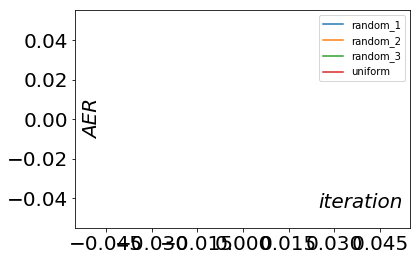

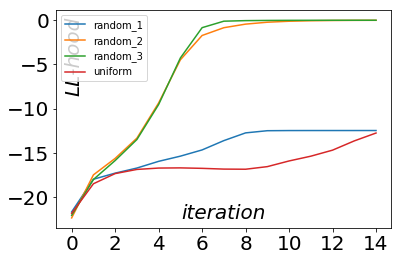

In [5]:
def add_plot_data(init_name, label):
    fname_ibm2_AERs = fname_ibm2(f'AERs_{init_name}.txt')    
    fname_ibm2_llhoods = fname_ibm2(f'llhoods_{init_name}.txt')
    AERs = persistence.load(fname_ibm2_AERs)
    llhoods = persistence.load(fname_ibm2_llhoods)
    AER_lines.append(AERs)
    llhood_lines.append(llhoods)
    model_names.append(label) 
    
AER_lines = []
llhood_lines = []
model_names = []
for i in [1,2,3]:
    init_name = f'IBM2_RR_{i}'
    add_plot_data(init_name, f'random_{i}')
add_plot_data('IBM2_uniform', 'uniform')
#add_plot_data('IBM2_staged')

plots.figure_AER_multiple_lines(AER_lines, model_names, fname_ibm2('IBM2_inits_AER.png'))
plots.figure_llhood_multiple_lines(llhood_lines, model_names, fname_ibm2('IBM2_inits_llhoods.png'))

# old file names
Just some helpers to identify the file names that contains the best AER and LL models for random initialization 

In [8]:
# Helpers for old generated files
def fname_best_random_AER():
    AER_selected_iterations = [7, 10, 8]
    selected_AER_scores = []
    for i in range(1,4):
        fname_ibm2_AERs = fname_ibm2(f'old/ibm2_AERs_IBM2_rr_{i}.txt')
        it_num = AER_selected_iterations[i - 1]
        AER_rr = persistence.load(fname_ibm2_AERs)[it_num]
        selected_AER_scores.append(AER_rr)
    min_AER = min(selected_AER_scores)
    rr_index = selected_AER_scores.index(min_AER) + 1
    it = AER_selected_iterations[rr_index - 1]
    fname = fname_ibm2(f'old/ibm2_IBM2_rr_{rr_index}_AER_{it}.txt')
    return fname

def fname_best_random_LL():
    LL_selected_iterations = [10, 10, 9]
    selected_LL_scores = []
    for i in range(1,4):
        fname_ibm2_LLs = fname_ibm2(f'old/ibm2_llhoods_IBM2_rr_{i}.txt')
        it_num = LL_selected_iterations[i - 1]
        LL_rr = persistence.load(fname_ibm2_LLs)[it_num]
        selected_LL_scores.append(LL_rr)
    max_LL = max(selected_LL_scores)
    rr_index = selected_LL_scores.index(max_LL) + 1
    it = LL_selected_iterations[rr_index - 1]
    fname = fname_ibm2(f'old/ibm2_IBM2_rr_{rr_index}_llhood_{it}.txt')
    return fname

# Step 3:
Evaluate the model on the test data using the official tool.
The result is 1) AER score in terminal 2) file in NAACL format that must be part of the submission
(for the best model)

In [16]:
def evaluate_IBM2_model(test_sentence_pairs, path_to_model, model_name):
    (lprobs, jump_probs) = persistence.load_ibm2_model(path_to_model)
    alignments = ibm2.align(lprobs, jump_probs, test_sentence_pairs)
    evaluate.evaluate_alignments_testset(model_name, alignments)    

model_name_AER = 'IBM2_RR_AER'
path_to_AER_model = fname_best_random_AER()
evaluate_IBM2_model(test_pairs, path_to_AER_model, model_name_AER)

model_name_LL = 'IBM2_RR_LL'
path_to_LL_model = fname_best_random_LL()
evaluate_IBM2_model(test_pairs, path_to_LL_model, model_name_LL)

File generated: IBM2_RR_AER.nonullalign.
Look in terminal to check if --IBM2_RR_AER.nonullalign-- is in NAACL format...
Look in terminal to see AER scores...
